In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch

import sys
sys.path.insert(0, '../fem')
from datasaver import *
from ManufacturedSolutionsDarcy import *

import sys
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NGO import NGO

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### FEM test dataset

In [12]:
#Test dataset
N_samples = 1000
theta_test = load_function_list('theta', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
f_test = load_function_list('f', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
etab_test = load_function_list('etab', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
etat_test = load_function_list('etat', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
x_test = np.load('../../../trainingdata/VarMiONpaperdata/test/x.npy')[:N_samples]
u_exact = np.load('../../../trainingdata/VarMiONpaperdata/test/u.npy')[:N_samples]
def g0(x):
    return np.zeros(x.shape[0])
g0set = []
for i in range(N_samples): 
    g0set.append(g0)
gl_test = g0set
gr_test = g0set

In [13]:
import torch
print(torch.__version__)

2.0.1


### Manufactured solutions test dataset

In [38]:
N_samples = 10

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_theta_min=0.5, l_theta_max=1, l_u_min=0.5/2, l_u_max=1/2)
# dataset = MFSetDarcy(N_samples=N_samples, d=2, l_theta_min=0.2, l_theta_max=0.4, l_u_min=0.2/2, l_u_max=0.4/2)
theta_test = dataset.theta
f_test = dataset.f
etat_test = dataset.etat
etab_test = dataset.etab
gl_test = dataset.gl
gr_test = dataset.gr
u_test = dataset.u

### Test error histograms

In [39]:
from NGO_D import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

sublogdir = 'MS_l5e-1to1e0_h64_100000epochs'
# DeepONet_UQ12 = loadmodelfromlabel(model=NGO, label='DeepONet_UQ12', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# VarMiON_UQ12 = loadmodelfromlabel(model=NGO, label='VarMiON_UQ12', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# NGO_UQ10 = loadmodelfromlabel(model=NGO, label='NGO_UQ10', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# NGO_GL10 = loadmodelfromlabel(model=NGO, label='NGO_GL10', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# NGO_UQ100 = loadmodelfromlabel(model=NGO, label='NGO_UQ100', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
NGO_GL100 = loadmodelfromlabel(model=NGO, label='NGO_GL100', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
FEM_GL100 = loadmodelfromlabel(model=NGO, label='NGO_GL100', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
FEM_GL100.hparams['modeltype'] = 'FEM'
FEM_GL100.hparams['gamma_stabilization'] = 100
proj_GL100 = loadmodelfromlabel(model=NGO, label='NGO_GL100', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
proj_GL100.hparams['modeltype'] = 'projection'

modeldict = {#'Projection': proj_GL100,
             'FEM': FEM_GL100,
            #'DeepONet': DeepONet_UQ12,
            #'VarMiON': VarMiON_UQ12,
            #'NGO, U 10x10': NGO_UQ10,
            #'NGO, G-L 10x10': NGO_GL10,
            #'NGO, U 100x100': NGO_UQ100,
            'NGO': NGO_GL100}

### Bulk

FEM
NGO


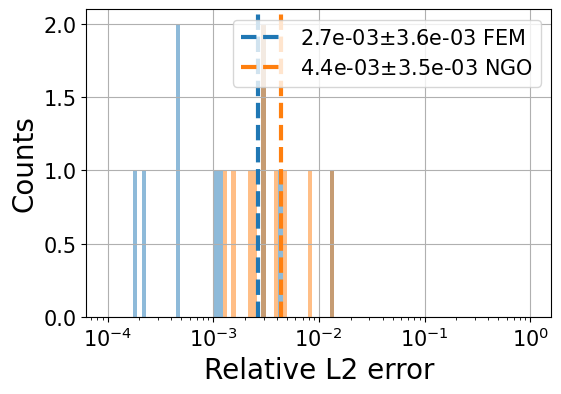

In [40]:
size_title = 20
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

x_test = np.random.uniform(0,1, size=(N_samples,268,2))
u_exact = []
for i in range(len(u_test)):
    u_exact.append(u_test[i](x_test[i]))
u_exact = np.array(u_exact)

j=0
for model in modeldict:
    print(str(model))
    u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, gl_test, gr_test, x_test, u_test)
    L2 = np.linalg.norm(u_hat - u_exact, ord=2, axis=-1)
    norm = np.linalg.norm(u_exact, ord=2, axis=-1)
    L2_scaled = (L2/norm)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(L2_scaled, bins=np.logspace(-4,0,100), density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    # ax.hist(L2_scaled, bins=100, density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    ax.axvline(L2_scaled_avg, 0, 1, linewidth=3, linestyle='--', color=colors[j], label=format(L2_scaled_avg, f".{1}e")+r'$\pm$'+format(sigma, f".{1}e")+' '+str(model))
    j+=1
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Relative L2 error', fontsize=size_axeslabels)
ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
ax.grid()
ax.set_xscale('log')
# ax.set_yscale('log')

# plt.savefig("bulk.svg", bbox_inches='tight')

In [3]:
def function(*args):
    return 0

x = np.array([0,1])
y = np.array([0,2])

### Test error histogram Dirichlet BC left

Projection
NGO


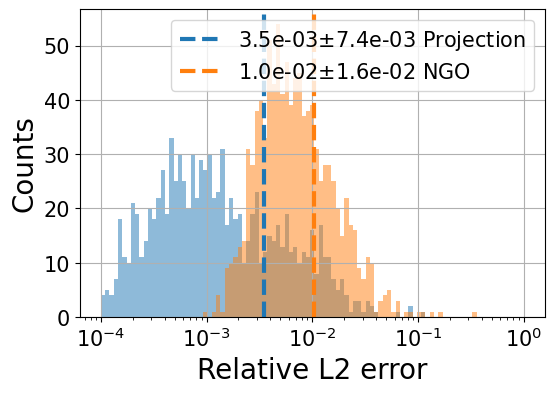

In [126]:
size_title = 20
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

x_test = np.random.uniform(0,1, size=(N_samples,268,2))
x_test[:,:,0] = 0

theta_exact = []
for i in range(len(theta_test)):
    theta_exact.append(theta_test[i](x_test[i]))
theta_exact = np.array(theta_exact)

gl_exact = []
for i in range(len(gl_test)):
    gl_exact.append(gl_test[i](x_test[i]))
gl_exact = np.array(gl_exact)

j=0
for model in modeldict:
    print(str(model))
    u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, gl_test, gr_test, x_test, u_test)
    L2 = np.linalg.norm(u_hat*theta_exact - gl_exact, ord=2, axis=-1)
    norm = np.linalg.norm(gl_exact, ord=2, axis=-1)
    L2_scaled = (L2/norm)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(L2_scaled, bins=np.logspace(-4,0,100), density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    # ax.hist(L2_scaled, bins=100, density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    ax.axvline(L2_scaled_avg, 0, 1, linewidth=3, linestyle='--', color=colors[j], label=format(L2_scaled_avg, f".{1}e")+r'$\pm$'+format(sigma, f".{1}e")+' '+str(model))
    j+=1
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Relative L2 error', fontsize=size_axeslabels)
ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
ax.grid()
ax.set_xscale('log')
# ax.set_yscale('log')

plt.savefig("gl.svg", bbox_inches='tight')

### Test error histogram Dirichlet BC right

Projection
NGO


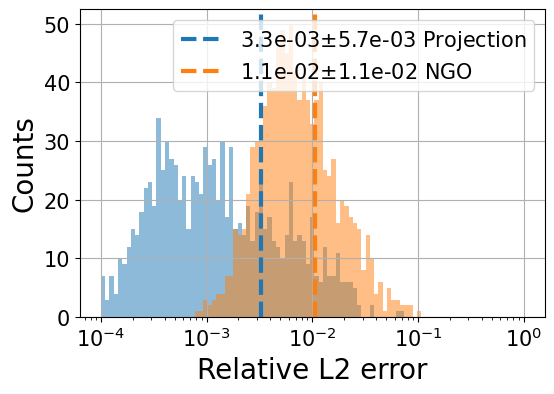

In [127]:
size_title = 20
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

x_test = np.random.uniform(0,1, size=(N_samples,268,2))
x_test[:,:,0] = 1

theta_exact = []
for i in range(len(theta_test)):
    theta_exact.append(theta_test[i](x_test[i]))
theta_exact = np.array(theta_exact)

gr_exact = []
for i in range(len(gr_test)):
    gr_exact.append(gr_test[i](x_test[i]))
gr_exact = np.array(gr_exact)

j=0
for model in modeldict:
    print(str(model))
    u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, gl_test, gr_test, x_test, u_test)
    L2 = np.linalg.norm(u_hat*theta_exact - gr_exact, ord=2, axis=-1)
    norm = np.linalg.norm(gr_exact, ord=2, axis=-1)
    L2_scaled = (L2/norm)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(L2_scaled, bins=np.logspace(-4,0,100), density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    # ax.hist(L2_scaled, bins=100, density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    ax.axvline(L2_scaled_avg, 0, 1, linewidth=3, linestyle='--', color=colors[j], label=format(L2_scaled_avg, f".{1}e")+r'$\pm$'+format(sigma, f".{1}e")+' '+str(model))
    j+=1
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Relative L2 error', fontsize=size_axeslabels)
ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
ax.grid()
ax.set_xscale('log')
# ax.set_yscale('log')

plt.savefig("gr.svg", bbox_inches='tight')

### Neumann bottom

Projection
NGO


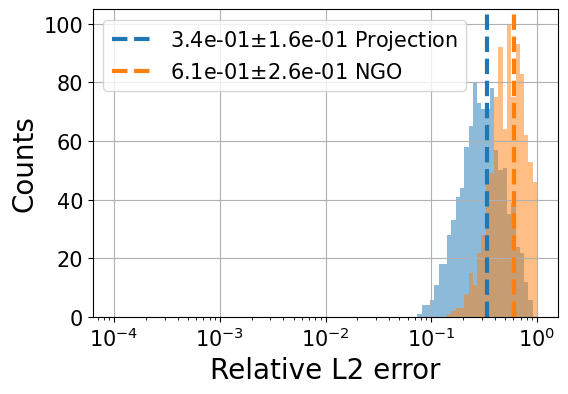

In [138]:
size_title = 20
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

x_test = np.random.uniform(0,1, size=(N_samples,268,2))
x_test[:,:,0] = 0

theta_exact = []
for i in range(len(theta_test)):
    theta_exact.append(theta_test[i](x_test[i]))
theta_exact = np.array(theta_exact)

etab_exact = []
for i in range(len(etab_test)):
    etab_exact.append(etab_test[i](x_test[i]))
etab_exact = np.array(etab_exact)

j=0
for model in modeldict:
    print(str(model))
    gradu_hat = modeldict[str(model)].simgrad(theta_test, f_test, etab_test, etat_test, gl_test, gr_test, x_test, u_test)
    L2 = np.linalg.norm(-1*gradu_hat[:,:,1]*theta_exact - etab_exact, ord=2, axis=-1)
    norm = np.linalg.norm(etab_exact, ord=2, axis=-1)
    L2_scaled = (L2/norm)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(L2_scaled, bins=np.logspace(-4,0,100), density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    # ax.hist(L2_scaled, bins=100, density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    ax.axvline(L2_scaled_avg, 0, 1, linewidth=3, linestyle='--', color=colors[j], label=format(L2_scaled_avg, f".{1}e")+r'$\pm$'+format(sigma, f".{1}e")+' '+str(model))
    j+=1
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Relative L2 error', fontsize=size_axeslabels)
ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
ax.grid()
ax.set_xscale('log')
# ax.set_yscale('log')

# plt.savefig("gr.svg", bbox_inches='tight')

### Neumann top

Projection
NGO


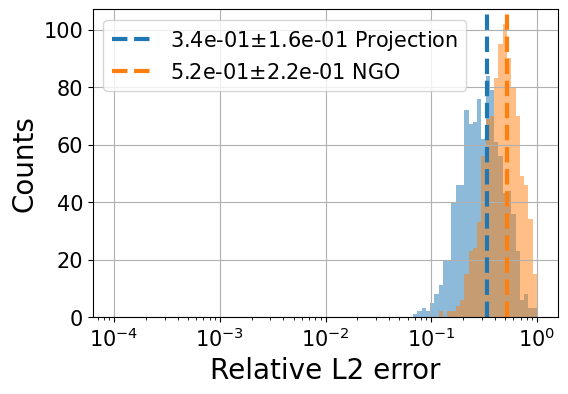

In [139]:
size_title = 20
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

x_test = np.random.uniform(0,1, size=(N_samples,268,2))
x_test[:,:,0] = 1

theta_exact = []
for i in range(len(theta_test)):
    theta_exact.append(theta_test[i](x_test[i]))
theta_exact = np.array(theta_exact)

etat_exact = []
for i in range(len(etat_test)):
    etat_exact.append(etat_test[i](x_test[i]))
etat_exact = np.array(etat_exact)

j=0
for model in modeldict:
    print(str(model))
    gradu_hat = modeldict[str(model)].simgrad(theta_test, f_test, etab_test, etat_test, gl_test, gr_test, x_test, u_test)
    L2 = np.linalg.norm(1*gradu_hat[:,:,1]*theta_exact - etat_exact, ord=2, axis=-1)
    norm = np.linalg.norm(etat_exact, ord=2, axis=-1)
    L2_scaled = (L2/norm)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(L2_scaled, bins=np.logspace(-4,0,100), density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    # ax.hist(L2_scaled, bins=100, density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    ax.axvline(L2_scaled_avg, 0, 1, linewidth=3, linestyle='--', color=colors[j], label=format(L2_scaled_avg, f".{1}e")+r'$\pm$'+format(sigma, f".{1}e")+' '+str(model))
    j+=1
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Relative L2 error', fontsize=size_axeslabels)
ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
ax.grid()
ax.set_xscale('log')
# ax.set_yscale('log')

# plt.savefig("gr.svg", bbox_inches='tight')

### Accuracy different FEMs versus $\gamma$

In [4]:
from NGO_D import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

sublogdir = 'MS_l5e-1to1e0_h64_100000epochs'

FEM_GL100 = loadmodelfromlabel(model=NGO, label='NGO_GL100', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
FEM_GL100.hparams['modeltype'] = 'FEM'


modeldict = {'FEM': FEM_GL100}

0
1
2
5
10
20
50
100
200
500
1000


/tmp/ipykernel_1112398/422092938.py:59: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(gammas, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


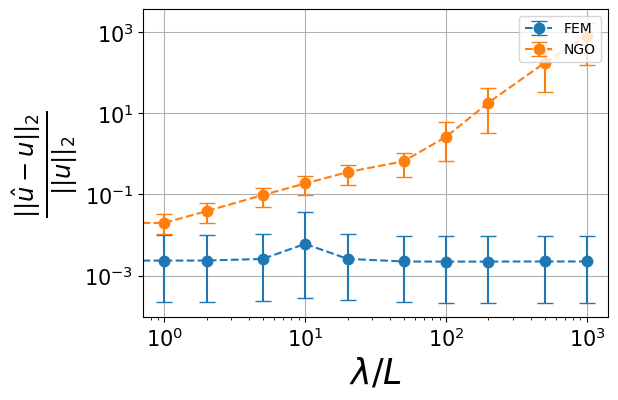

In [53]:
N_samples = 100

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

gammas = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])

L2_scaled_avg = np.zeros((len(modeldict),len(gammas)))
yerr = np.zeros((len(modeldict),2,len(gammas)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

linestyles=['--','--','--','--','--','--','--']

colors = ['C0','C1','C2','C3','C4','C5','C6']

x_test = np.random.uniform(0,1, size=(N_samples,268,2))
u_exact = []
for i in range(len(u_test)):
    u_exact.append(u_test[i](x_test[i]))
u_exact = np.array(u_exact)

for i in range(len(gammas)):
    print(gammas[i])
    m=0
    for model in modeldict:
        modeldict[str(model)].hparams['gamma_stabilization'] = gammas[i]
        u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, gl_test, gr_test, x_test, u_test)
        L2 = np.linalg.norm(u_hat - u_exact, ord=2, axis=-1)
        norm = np.linalg.norm(u_exact, ord=2, axis=-1)
        L2_scaled_array = (L2/norm)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1
        
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
# plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'$\lambda/L$', fontsize=size_axeslabels)
# ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(0, 1.05)
# ax.set_ylim(1e-4, 1e4)
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.grid()
for model in modeldict:
    plots.append(ax.errorbar(gammas, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
        # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
    m+=1
    # plt.legend(fontsize=10, loc='upper right')
    # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
plt.legend(fontsize=10, loc='upper right')
# legend1 = ax.legend(handles=[plots[0],plots[1],plots[2],plots[3],plots[4],plo],fontsize=10, loc='upper right')
# plt.gca().add_artist(legend1)
# plt.legend(handles=[plots[7]],fontsize=10, loc='lower left')
plt.savefig("all.svg", bbox_inches='tight')#, transparent=True)

plt.show()

### Accuracy different NOs versus $\lambda$

In [137]:
from NGO_D import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

sublogdir = 'MS_l5e-1to1e0_h64_100000epochs'

UQ10 = loadmodelfromlabel(model=NGO, label='NGO_UQ10', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
GL10 = loadmodelfromlabel(model=NGO, label='NGO_GL10', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
UQ100 = loadmodelfromlabel(model=NGO, label='NGO_UQ100', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
GL100 = loadmodelfromlabel(model=NGO, label='NGO_GL100', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

modeltype = 'projection'

UQ10.hparams['modeltype'] = modeltype
UQ10.hparams['gamma_stabilization'] = 100
UQ100.hparams['modeltype'] = modeltype
UQ100.hparams['gamma_stabilization'] = 100
GL10.hparams['modeltype'] = modeltype
GL10.hparams['gamma_stabilization'] = 100
GL100.hparams['modeltype'] = modeltype
GL100.hparams['gamma_stabilization'] = 100

modeldict = {'U 10x10': UQ10,
            'G-L 10x10': GL10,
            'U 100x100': UQ100,
            'G-L 100x100': GL100}

1.0
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


/tmp/ipykernel_2507821/4249309586.py:68: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(l, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


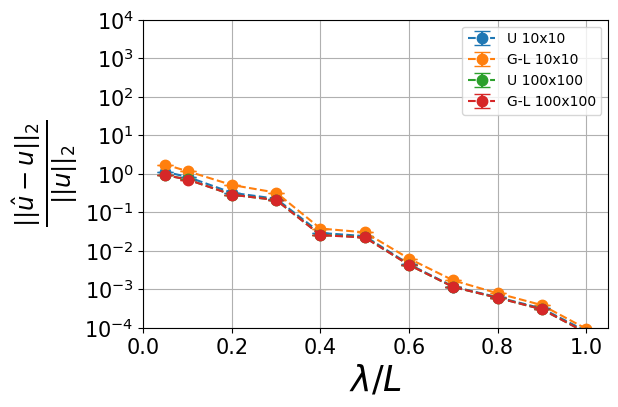

In [138]:
N_samples = 1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

# l = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
l = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
# l = np.array([1])

# l = np.array([0.4, 0.3, 0.2, 0.1, 0.05])
L2_scaled_avg = np.zeros((len(modeldict),len(l)))
yerr = np.zeros((len(modeldict),2,len(l)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

x_test = np.random.uniform(0,1, size=(N_samples,268,2))

linestyles=['--','--','--','--','--','--','--']

colors = ['C0','C1','C2','C3','C4','C5','C6']
    
for i in range(len(l)):
    print(l[i])
    dataset = MFSetDarcy(N_samples=N_samples, d=2, l_theta_min=l[i], l_theta_max=l[i], l_u_min=l[i]/2, l_u_max=l[i]/2)
    theta_test = dataset.theta
    f_test = dataset.f
    etat_test = dataset.etat
    etab_test = dataset.etab
    gl_test = dataset.gl
    gr_test = dataset.gr
    u_test = dataset.u
    u_exact = []
    for j in range(len(u_test)):
        u_exact.append(u_test[j](x_test[j]))
    u_exact = np.array(u_exact)
    m=0
    for model in modeldict:
        u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, gl_test, gr_test, x_test, u_test)
        L2 = np.linalg.norm(u_hat - u_exact, ord=2, axis=-1)
        norm = np.linalg.norm(u_exact, ord=2, axis=-1)
        L2_scaled_array = (L2/norm)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1
        
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
# plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'$\lambda/L$', fontsize=size_axeslabels)
# ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.set_xlim(0, 1.05)
ax.set_ylim(1e-4, 1e4)
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.grid()
for model in modeldict:
    plots.append(ax.errorbar(l, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
        # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
    m+=1
    # plt.legend(fontsize=10, loc='upper right')
    # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
plt.legend(fontsize=10, loc='upper right')
# legend1 = ax.legend(handles=[plots[0],plots[1],plots[2],plots[3],plots[4],plo],fontsize=10, loc='upper right')
# plt.gca().add_artist(legend1)
# plt.legend(handles=[plots[7]],fontsize=10, loc='lower left')
# plt.savefig("all.svg", bbox_inches='tight')#, transparent=True)

plt.show()

### Training error

In [24]:
from NGO_D import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

sublogdir = 'MS_l5e-1to1e0_h64_trainingerror'
proj = loadmodelfromlabel(model=NGO, label='10000epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
proj.hparams['modeltype'] = 'projection'
FEM = loadmodelfromlabel(model=NGO, label='10000epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
FEM.hparams['modeltype'] = 'FEM' 
FEM.hparams['gamma_stabilization'] = 100
e1e2 = loadmodelfromlabel(model=NGO, label='100epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
e2e2 = loadmodelfromlabel(model=NGO, label='200epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
e5e2 = loadmodelfromlabel(model=NGO, label='500epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
e1e3 = loadmodelfromlabel(model=NGO, label='1000epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
e2e3 = loadmodelfromlabel(model=NGO, label='2000epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
e5e3 = loadmodelfromlabel(model=NGO, label='5000epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
e1e4 = loadmodelfromlabel(model=NGO, label='10000epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
e2e4 = loadmodelfromlabel(model=NGO, label='20000epochs', logdir=logdir, sublogdir=sublogdir, map_location=map_location)


modeldict = {'Projection': proj,
             'FEM': FEM,
            '1e2 epochs': e1e2,
            #'2e2 epochs': e2e2,
            #'5e2 epochs': e5e2,
            '1e3 epochs': e1e3,
            #'2e3 epochs': e2e3,
            #'5e3 epochs': e5e3,
            '1e4 epochs': e1e4,
            #'2e4 epochs': e2e4,
            '5e4 epochs': NGO_GL100}

In [ ]:
N_samples = 100

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

# l = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
l = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
# l = np.array([1])
# l = np.array([1, 0.1])

# l = np.array([0.4, 0.3, 0.2, 0.1, 0.05])
L2_scaled_avg = np.zeros((len(modeldict),len(l)))
yerr = np.zeros((len(modeldict),2,len(l)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

x_test = np.random.uniform(0,1, size=(N_samples,268,2))

colors = ['black','grey','C0','C1','C2','C3','C4','C5','C6']
linestyles = ['-','-','--','--','--','--','--','--','--']
      
for i in range(len(l)):
    print(l[i])
    dataset = MFSetDarcy(N_samples=N_samples, d=2, l_theta_min=l[i], l_theta_max=l[i], l_u_min=l[i]/2, l_u_max=l[i]/2)
    theta_test = dataset.theta
    f_test = dataset.f
    etat_test = dataset.etat
    etab_test = dataset.etab
    gl_test = dataset.gl
    gr_test = dataset.gr
    u_test = dataset.u
    u_exact = []
    for j in range(len(u_test)):
        u_exact.append(u_test[j](x_test[j]))
    u_exact = np.array(u_exact)
    m=0
    for model in modeldict:
        u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, gl_test, gr_test, x_test, u_test)
        L2 = np.linalg.norm(u_hat - u_exact, ord=2, axis=-1)
        norm = np.linalg.norm(u_exact, ord=2, axis=-1)
        L2_scaled_array = (L2/norm)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1
        
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
# plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
for model in modeldict:
    plots.append(ax.errorbar(l, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'$\lambda/L$', fontsize=size_axeslabels)
# ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.set_xlim(0, 1.05)
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.grid()
legend1 = ax.legend(handles=[plots[0],plots[1],plots[2]],fontsize=10, loc='upper right')
plt.gca().add_artist(legend1)
plt.legend(handles=[plots[3],plots[4],plots[5],plots[6]],fontsize=10, loc='lower left')
# plt.savefig("errorvsl_1000samples_new.pdf", bbox_inches='tight')#, transparent=True)
plt.savefig("trainingerror_highstats.pdf", bbox_inches='tight')#, transparent=True)

plt.show()